In [2]:
!conda activate ~/tensorflow-work/env


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [1]:
try:
    import json
    import os
    
    import pandas as  pd
    import spacy
    
    import seaborn as sns
    import string

    from tqdm import tqdm
    from textblob import TextBlob
    
    from nltk.corpus import stopwords
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize
    import re
    
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    
    
    from sklearn.preprocessing import FunctionTransformer
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import FeatureUnion
    from sklearn.feature_extraction import DictVectorizer
    
    import swifter
    
    tqdm.pandas()
except Exception as e:
    print("Error : {} ".format(e))

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv("educated.csv", low_memory=False)
df = df.astype(str)
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
# df = df.loc[df["category"] == "Photography and Video", ["text", "sub_category"]]

In [5]:
df = df[["text", "category"]]
print(df.duplicated().sum())
df.drop_duplicates(keep="first", inplace=True)
print(df.duplicated().sum())

4107
0


In [6]:
print(df["text"].duplicated().sum())
df = df.drop_duplicates(subset="text", keep="first")
print(df["text"].duplicated().sum())

109
0


In [7]:
# df.loc[df["sub_category"] == "Other Photography and Video Design", "sub_category"] = "Other Photography and Video"

In [8]:
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

text        0
category    0
dtype: int64
text        0
category    0
dtype: int64


<AxesSubplot:>

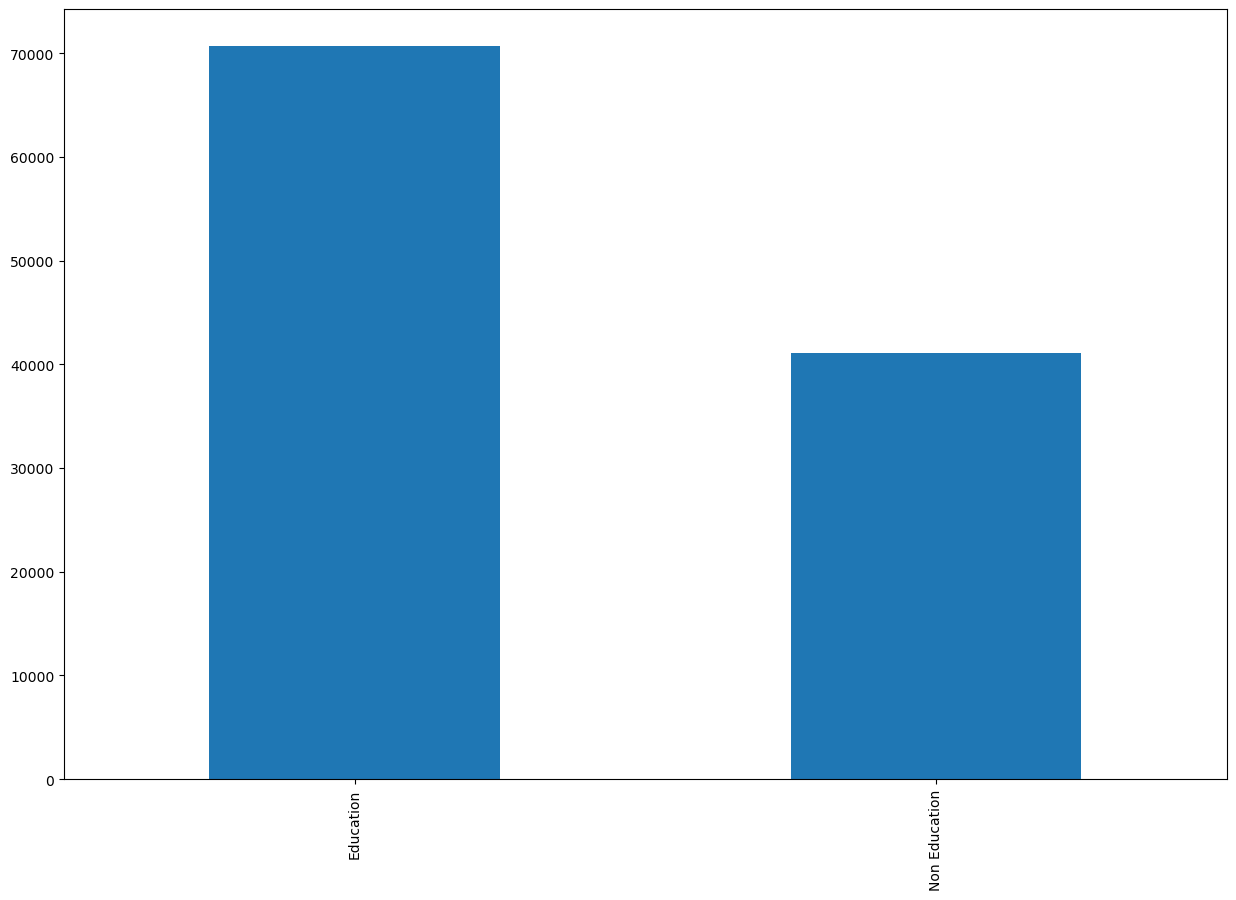

In [9]:
# df = df.head(25000)
df['category'].value_counts().plot( kind='bar', figsize=(15,10))

In [10]:
df.shape

(111791, 2)

In [11]:
df.columns

Index(['text', 'category'], dtype='object')

In [12]:
df.describe()

,text,category
count,111791,111791
unique,111791,2
top,React: Building a New UI - Live Coding with Je...,Education
freq,1,70727


In [13]:
df.isnull().sum()

text        0
category    0
dtype: int64

In [14]:
df['category'].unique()

array(['Education', 'Non Education'], dtype=object)

In [16]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [17]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

def polarity_txt(text):
    return TextBlob(text).sentiment[0]

def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

In [18]:
df['text'] = df['text'].swifter.apply(clean_txt)
df['polarity'] = df['text'].swifter.apply(polarity_txt)
df['subjectivity'] = df['text'].swifter.apply(subj_txt)
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/111791 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111791 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111791 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/111791 [00:00<?, ?it/s]

In [100]:
X = df[['text', 'polarity', 'subjectivity','len']]
y = df['category']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
v = dict(zip(list(y), df['category'].to_list()))

In [101]:
# x_train = x_train.sample(frac=1)

In [102]:
# text_clf = Pipeline([
#     ('vect', CountVectorizer(analyzer="word", stop_words="english")),
#     ('tfidf', TfidfTransformer(use_idf=True)),
#     ('clf', MultinomialNB(alpha=.01)),
# ])

# text_clf = Pipeline([
#     ('vect', TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))),
#     ('chi',  SelectKBest(chi2, k=1200)),
#     ('clf', RandomForestClassifier())
# ])

text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer="word", stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('chi',  SelectKBest(chi2, k=1200)),
    ('clf', RandomForestClassifier())
])

In [103]:
text_clf.fit(x_train['text'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x2c02c1fc0>)),
                ('clf', RandomForestClassifier())])

In [104]:
import numpy as np

In [105]:
X_TEST = x_test['text'].to_list()
Y_TEST = list(y_test)

In [106]:
predicted = text_clf.predict(X_TEST)

In [107]:
c = 0

for dec, category in zip(X_TEST, predicted):
    
    if c == 2:break
    
    print("-"*55)
    print(dec)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
blackpink shut cardio dance cardio workout cardio cardiodance cardioworkout kpop shutdown blackpink golfy dance fitness
Education
-------------------------------------------------------
-------------------------------------------------------
carly rae jepsen talk official lyric video listen talk https carlyrraejepsen lnk talkingtoyourself listen loneliest time https carlyraejepsen lnk theloneliesttime watch official visual talk https carlyraejepsen lnk talkingtoyourselfvisual follow carly rae jepsen instagram https carlyraejepsen lnk instagram twitter https carlyraejepsen lnk twitter tiktok https carlyraejepsen lnk tiktok facebook https carlyraejepsen lnk facebook youtube https carlyraejepsen lnk youtube always invisible consequences difficult face could something beautiful make impossible stay tell get mind get mind get mind keep night keep night never let think somebody else talk talk reach make love someone else talk talk self 

In [108]:
np.mean(predicted == Y_TEST)

0.9628801431127012

In [109]:
title_plus_des = ["""
Say yes to healthy living with CureFit!

Download the Cultfit app to access more such content - https://bit.ly/30pXU5L

0:00 Intro
1:08 1 - Jumping Jacks
2:14 2 - Mountain Climbers
3:31- 3 - Elbow Plank
4:47 4 - Flutter Kicks
5:56 5 - High Knees
7:01 6 - Russian Twists
8:23 7 - Leg Tuck Ins
9:35 Download cure.fit app
10:04 8 - Bicycle Crunches
12:15 Subscribe and show some love

Follow Suvini on Instagram:- https://www.instagram.com/suvini.mehra/

Check out our Fat Loss Workouts playlist by Cult Fit: https://www.youtube.com/watch?v=yx2kR...

Subscribe to CureFit channel now: https://www.youtube.com/c/CureFit?sub...

We make group workouts fun, daily food healthy & tasty, mental fitness easy with yoga & meditation, and medical & lifestyle care hassle-free. #BeBetterEveryDay #Bellyworkout #CureFit

"""]
predicted = text_clf.predict(title_plus_des)
v, v[predicted[0]]

({0: 'Education', 1: 'Non Education'}, 'Education')

In [110]:
import pickle
with open('models/educated_model.pkl','wb') as f:
    pickle.dump(text_clf,f)

In [111]:
import pickle
with open('models/educated_model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [115]:
des = ['''
intense workout, stay fit and healthy''']
predicted = clf2.predict_proba(des)

In [116]:
print(predicted[0])
max(predicted[0])

[0.94 0.06]


0.94

In [117]:
v[clf2.predict(des)[0]]

'Education'

# New Model

In [23]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("END_OF_EDU_AND_NON_EDU.csv", low_memory=False)
df = df.astype(str)
df = df.sample(frac=1).reset_index(drop=True)

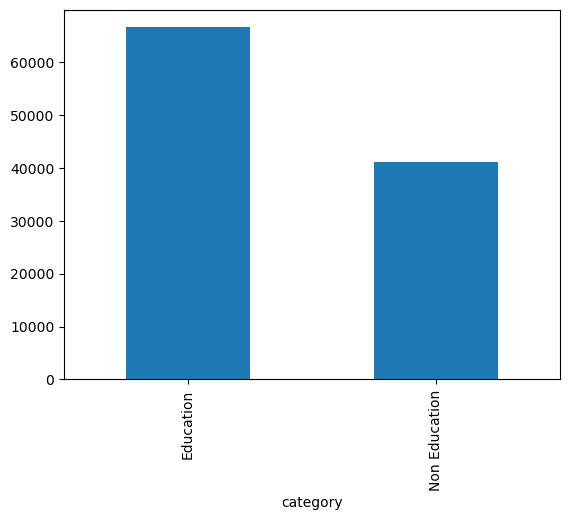

In [5]:
df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [7]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
df['cleaned'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshulnanda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df.head()

,Unnamed: 0,text,category,cleaned
0,15118,How To Draw A Shark | Draw with Blippi | Arts ...,Non Education,how to draw a shark draw blippi art craft for ...
1,3717,BLACK ADAM - Official Trailer Dwayne ‘The Rock...,Non Education,black adam offici trailer dwayn the rock johns...
2,15429,girl,Non Education,girl
3,73054,Hands-On Unity 2018.x Game Development for Mob...,Education,hand on uniti x game develop mobil load asset ...
4,96020,Mobile AppSec from an attacker's perspective -...,Education,mobil appsec attack perspect abhisek datta app...


In [9]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

In [ ]:
# this block is to split the dataset into training and testing set 
X = df['cleaned']
Y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))